In [13]:
import os
import shutil
import torch
import torchvision
from torchvision.models import ResNet18_Weights
from torchvision import models
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import trange
from torchvision.transforms import Grayscale
import matplotlib.pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 567
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

#"/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
data_transforms = {
    "train": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to VGG16-compatible dimensions (just to keep it consistent with the future)
        transforms.RandomHorizontalFlip(),  # Augmentation
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
    ]),
    "val": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    "test": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

data_dir = "/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
datasets = {
    x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4) # Try smaller batch sizes [8,16]
    for x in ["train", "val", "test"]
}

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

def ResNet18(num_classes=2):
    # Load pretrained ResNet18
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # Modify the first convolutional layer for grayscale input
    model.conv1 = nn.Conv2d(
        in_channels=1,  # Change from 3 (RGB) to 1 (grayscale)
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )
    
    # Modify the final fully connected layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # 2 classes: usable/unusable
    
    return model

# Initialize model
model = ResNet18(num_classes=2).to(DEVICE)

# Try AdaGrad optimizer with normal x-entropy loss
optimizer = optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(loader, model, device, optimizer, criterion, log_interval, epoch):
    model.train()
    total_loss = 0
    correct = 0
    losses = []
    counter = []

    for i, (img, label) in enumerate(loader):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
        
        if (i + 1) % log_interval == 0:
            losses.append(loss.item())
            counter.append((i * loader.batch_size) + len(img) + epoch * len(loader.dataset))

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy, losses, counter

def evaluate(loader, model, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for img, label in loader:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(label).sum().item()

            predictions.extend(pred.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy, predictions, true_labels

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/quentin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 41.3MB/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# train loop
max_epochs = 20
patience = 2 # Early stopping (i.e. loss doesn't improve for patience # of epochs)
best_val_loss = float('inf')
p_counter = 0
log_interval = 7

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
log_losses = []
log_counter = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    # Train
    train_loss, train_accuracy, train_log_loss, train_log_counter = train_one_epoch(train_loader, model, DEVICE, optimizer, criterion, log_interval, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    log_losses.extend(train_log_loss)  # log losses
    log_counter.extend(train_log_counter)  # log counters

    # Validate
    val_loss, val_accuracy,val_pred, val_labels = evaluate(val_loader, model, DEVICE, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_resnet.pth")  # Save the best model
        p_counter = 0  # Reset patience counter
    else:
        p_counter += 1
        if p_counter >= patience:
            print(f"Early stopping triggered! TOTAL EPOCHS = {epoch}")
            break

Epochs:   5%|█▋                               | 1/20 [03:45<1:11:21, 225.35s/it]

Epoch 1:
Train Loss: 0.3636, Train Accuracy: 0.8540
Val Loss: 0.7699, Val Accuracy: 0.5360


Epochs:  10%|███▎                             | 2/20 [07:49<1:10:56, 236.46s/it]

Epoch 2:
Train Loss: 0.1447, Train Accuracy: 0.9789
Val Loss: 0.1421, Val Accuracy: 0.9820


Epochs:  15%|████▉                            | 3/20 [15:07<1:33:05, 328.54s/it]

Epoch 3:
Train Loss: 0.0808, Train Accuracy: 0.9937
Val Loss: 0.0830, Val Accuracy: 0.9928


python(14794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  20%|██████▌                          | 4/20 [19:17<1:19:19, 297.46s/it]

Epoch 4:
Train Loss: 0.0531, Train Accuracy: 0.9973
Val Loss: 0.0638, Val Accuracy: 0.9928


python(15100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  25%|████████▎                        | 5/20 [23:19<1:09:19, 277.29s/it]

Epoch 5:
Train Loss: 0.0358, Train Accuracy: 0.9987
Val Loss: 0.0471, Val Accuracy: 0.9928


python(15343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  30%|█████████▉                       | 6/20 [27:04<1:00:33, 259.56s/it]

Epoch 6:
Train Loss: 0.0276, Train Accuracy: 0.9991
Val Loss: 0.0377, Val Accuracy: 0.9964


python(15593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  35%|████████████▎                      | 7/20 [31:27<56:32, 260.93s/it]

Epoch 7:
Train Loss: 0.0221, Train Accuracy: 1.0000
Val Loss: 0.0338, Val Accuracy: 0.9964


python(15836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  40%|██████████████                     | 8/20 [35:51<52:21, 261.82s/it]

Epoch 8:
Train Loss: 0.0167, Train Accuracy: 1.0000
Val Loss: 0.0419, Val Accuracy: 0.9964


python(16221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  45%|███████████████▊                   | 9/20 [40:30<48:58, 267.16s/it]

Epoch 9:
Train Loss: 0.0143, Train Accuracy: 1.0000
Val Loss: 0.0291, Val Accuracy: 0.9964


python(16569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epochs:  50%|█████████████████                 | 10/20 [44:28<43:00, 258.07s/it]

Epoch 10:
Train Loss: 0.0120, Train Accuracy: 1.0000
Val Loss: 0.0252, Val Accuracy: 0.9964


python(16899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


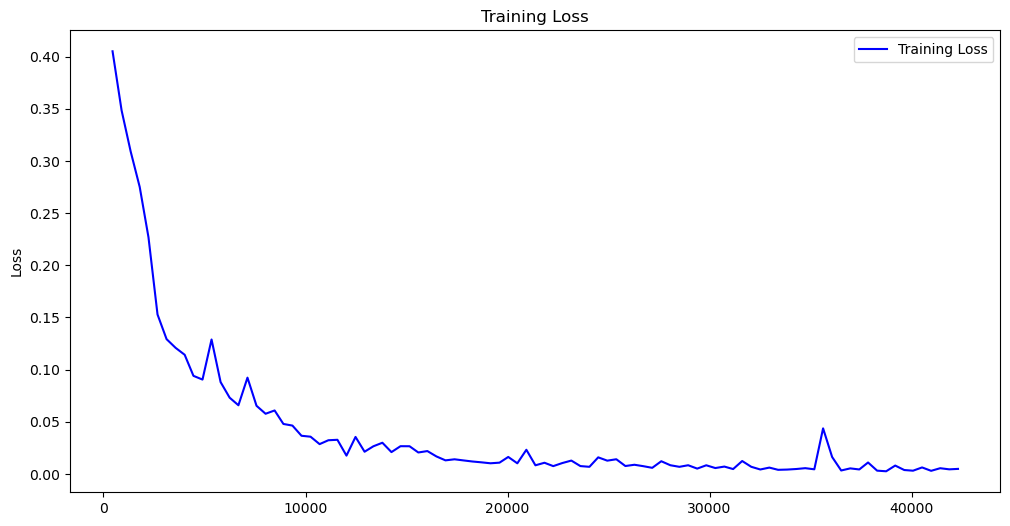

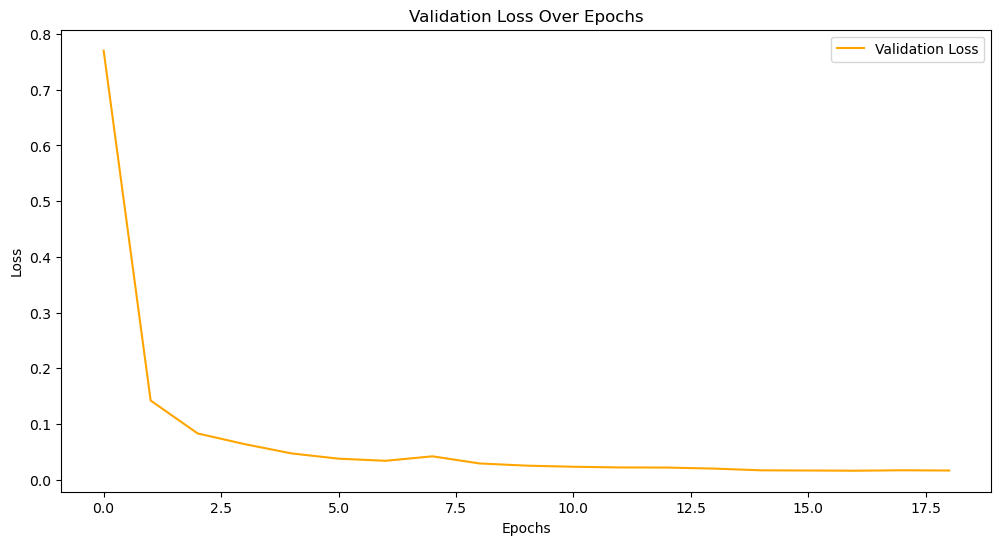

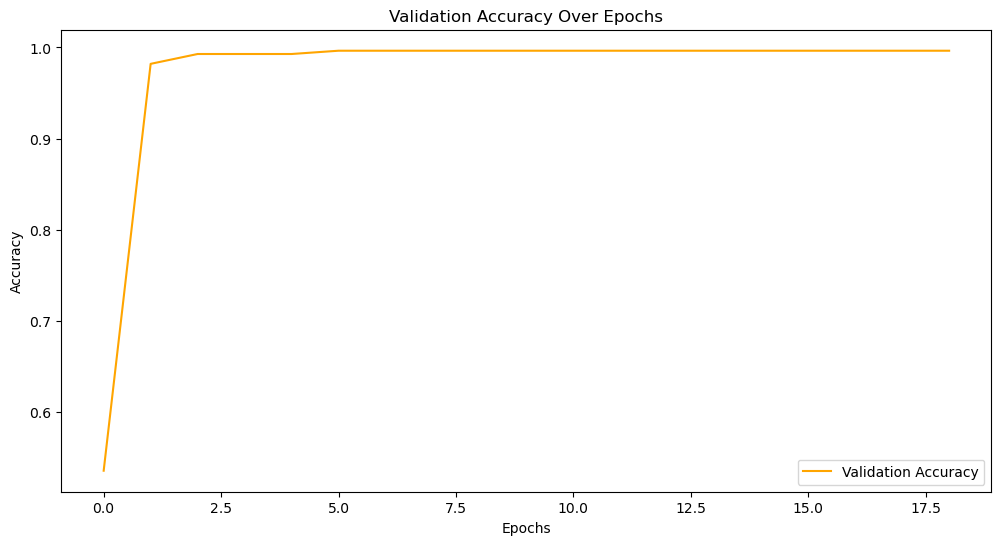

In [ ]:
# Plot results
# epoch counter 
plt.figure(figsize=(12, 6))
plt.plot(log_counter, log_losses, color='blue', label='Training Loss')
plt.legend()
plt.title("Training Loss"); plt.ylabel('Loss')

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_losses)), val_losses, color='orange', label='Validation Loss')
#plt.plot(range(max_epochs), test_losses, color='green', label='Test Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title("Validation Loss Over Epochs")
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='Validation Accuracy')
#plt.plot(range(max_epochs), test_accuracies, color='green', label='Test Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title("Validation Accuracy Over Epochs")
plt.legend()

plt.show()

In [22]:
import time

start_time = time.time()

# Load the best model before testing
model.load_state_dict(torch.load("best_model_resnet.pth", weights_only = True))
test_loss, test_accuracy, test_pred, test_labels = evaluate(test_loader, model, DEVICE, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


end_time = time.time()

elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Total training time: {int(minutes)} minutes and {int(seconds)} seconds")


python(25642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Loss: 0.0087, Test Accuracy: 1.0000
Total training time: 0 minutes and 32 seconds


python(25896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


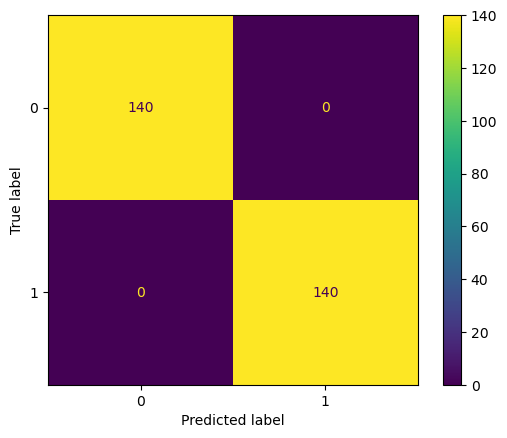

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)

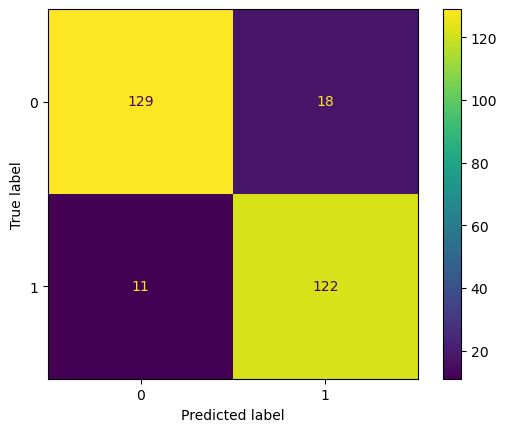

In [1]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

# Load the CSV file
file_path = "/Users/quentin/Desktop/ML_MRIqc_DATASET/example_save_resnet/test_predictions.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Extract true labels and predictions
true_labels = df.iloc[:, 0]  # Assuming true labels are in the first column
predictions = df.iloc[:, 1]  # Assuming predictions are in the second column

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(true_labels, predictions)
